<a href="https://colab.research.google.com/github/saahil-jain/Covid_19_predictor/blob/master/CasesDeathsGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os

Using TensorFlow backend.


In [2]:
print(os.getcwd())
if os.getcwd().split("/")[-1] == "Covid_19_predictor":
  print("Current working directory is already Covid_19_predictor")
elif os.path.isdir("Covid_19_predictor"):
  print("Covid_19_predictor already Exists")
else:
  ! git clone https://github.com/saahil-jain/Covid_19_predictor.git

/content
Covid_19_predictor already Exists


In [3]:
if os.path.isdir("Covid_19_predictor"):
  % cd Covid_19_predictor
! git pull

/content/Covid_19_predictor
Already up to date.


In [0]:
df = pd.read_csv('data.csv' , usecols = ['countriesAndTerritories'])
ctcset = set()
for i in range(len(df.values)):
  ctcset.add(df.values[i][0])
ctclist = list(ctcset)
ctclist = ["United_States_of_America", "France", "Italy"]

In [0]:
date_parse = lambda x: pd.datetime.strptime(x, "%d/%m/%Y")

In [6]:
df = pd.read_csv('data.csv' , date_parser=['dateRep'])
dfs = {}
for ctc in ctclist:
  dftemp = pd.read_csv('data.csv', parse_dates = ['dateRep'], date_parser = date_parse)
  dftemp = dftemp.loc[df['countriesAndTerritories'] == ctc]
  dftemp["dateRep"] = pd.to_datetime(dftemp["dateRep"])
  dftemp = dftemp.sort_values(by="dateRep")
  dfs[ctc] = dftemp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [0]:
dfs_cases = {}
datasets_cases = {}
dfs_deaths = {}
datasets_deaths = {}
for ctc in ctclist:
  dfs_cases[ctc] = dfs[ctc]['cases']
  datasets_cases[ctc] = dfs_cases[ctc].values
  dfs_deaths[ctc] = dfs[ctc]['deaths']
  datasets_deaths[ctc] = dfs_deaths[ctc].values
  datasets_cases[ctc] = datasets_cases[ctc].astype('float32')
  datasets_deaths[ctc] = datasets_deaths[ctc].astype('float32')

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
for ctc in ctclist:
  datasets_cases[ctc] = np.array(datasets_cases[ctc]).reshape(-1 , 1)
  datasets_deaths[ctc] = np.array(datasets_deaths[ctc]).reshape(-1 , 1)
  datasets_cases[ctc] = scaler.fit_transform(datasets_cases[ctc])
  datasets_deaths[ctc] = scaler.fit_transform(datasets_deaths[ctc])

In [0]:
trains_cases = {}
tests_cases = {}
trains_deaths = {}
tests_deaths = {}
for ctc in ctclist:
  train_size_cases = int(len(datasets_cases[ctc]) * 0.7)
  test_size_cases = len(datasets_cases[ctc]) - train_size_cases
  trains_cases[ctc], tests_cases[ctc] = datasets_cases[ctc][0:train_size_cases], datasets_cases[ctc][train_size_cases:len(datasets_cases[ctc])]
  train_size_deaths = int(len(datasets_deaths[ctc]) * 0.7)
  test_size_deaths = len(datasets_deaths[ctc]) - train_size_deaths
  trains_deaths[ctc], tests_deaths[ctc] = datasets_deaths[ctc][0:train_size_deaths], datasets_deaths[ctc][train_size_deaths:len(datasets_deaths[ctc])]

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [0]:
look_back = 1
trainXs_cases = {}
trainYs_cases = {}
trainXs_deaths = {}
trainYs_deaths= {}
testXs_cases = {}
testYs_cases = {}
testXs_deaths = {}
testYs_deaths= {}
for ctc in ctclist:
  trainXs_cases[ctc], trainYs_cases[ctc] = create_dataset(trains_cases[ctc], look_back)
  testXs_cases[ctc], testYs_cases[ctc] = create_dataset(tests_cases[ctc], look_back)

  trainXs_deaths[ctc], trainYs_deaths[ctc] = create_dataset(trains_deaths[ctc], look_back)
  testXs_deaths[ctc], testYs_deaths[ctc] = create_dataset(tests_deaths[ctc], look_back)

In [0]:
for ctc in ctclist:
  trainXs_cases[ctc] = np.reshape(trainXs_cases[ctc], (trainXs_cases[ctc].shape[0], 1, trainXs_cases[ctc].shape[1]))
  testXs_cases[ctc] = np.reshape(testXs_cases[ctc], (testXs_cases[ctc].shape[0], 1, testXs_cases[ctc].shape[1]))

  trainXs_deaths[ctc] = np.reshape(trainXs_deaths[ctc], (trainXs_deaths[ctc].shape[0], 1, trainXs_deaths[ctc].shape[1]))
  testXs_deaths[ctc] = np.reshape(testXs_deaths[ctc], (testXs_deaths[ctc].shape[0], 1, testXs_deaths[ctc].shape[1]))

In [13]:
# The GRU architecture
regressorGRU_cases = Sequential()
regressorGRU_cases.add(GRU(units=50, return_sequences=True, input_shape=(1, look_back), activation='tanh'))
regressorGRU_cases.add(Dropout(0.2))
regressorGRU_cases.add(GRU(units=50, return_sequences=True, input_shape=(1, look_back), activation='tanh'))
regressorGRU_cases.add(Dropout(0.2))
regressorGRU_cases.add(GRU(units=50, return_sequences=True, input_shape=(1, look_back), activation='tanh'))
regressorGRU_cases.add(Dropout(0.2))
regressorGRU_cases.add(GRU(units=50, activation='tanh'))
regressorGRU_cases.add(Dropout(0.2))
regressorGRU_cases.add(Dense(units=1))
regressorGRU_cases.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
for ctc in ctclist:
    regressorGRU_cases.fit(trainXs_deaths[ctc], trainYs_deaths[ctc], epochs=53, batch_size=1)

regressorGRU_deaths = Sequential()
regressorGRU_deaths.add(GRU(units=50, return_sequences=True, input_shape=(1, look_back), activation='tanh'))
regressorGRU_deaths.add(Dropout(0.2))
regressorGRU_deaths.add(GRU(units=50, return_sequences=True, input_shape=(1, look_back), activation='tanh'))
regressorGRU_deaths.add(Dropout(0.2))
regressorGRU_deaths.add(GRU(units=50, return_sequences=True, input_shape=(1, look_back), activation='tanh'))
regressorGRU_deaths.add(Dropout(0.2))
regressorGRU_deaths.add(GRU(units=50, activation='tanh'))
regressorGRU_deaths.add(Dropout(0.2))
regressorGRU_deaths.add(Dense(units=1))
regressorGRU_deaths.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
for ctc in ctclist:
    regressorGRU_deaths.fit(trainXs_deaths[ctc], trainYs_deaths[ctc], epochs=53, batch_size=1)

Epoch 1/53
108/108 [==============================] - 2s 15ms/step - loss: 0.0244
Epoch 2/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0257
Epoch 3/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0244
Epoch 4/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0265
Epoch 5/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0273
Epoch 6/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0234
Epoch 7/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0266
Epoch 8/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 9/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 10/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 11/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0257
Epoch 12/53
108/108 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 13/53
108/108 [===

In [0]:
trainPredicts_cases = {}
testPredicts_cases = {}
trainPredicts_deaths = {}
testPredicts_deaths = {}
trainScores_cases = {}
trainScores_deaths = {}
for ctc in ctclist:
  trainPredicts_cases[ctc] = regressorGRU_cases.predict(trainXs_cases[ctc])
  testPredicts_cases[ctc] = regressorGRU_cases.predict(testXs_cases[ctc])

  trainPredicts_cases[ctc] = scaler.inverse_transform(trainPredicts_cases[ctc])
  trainYs_cases[ctc] = scaler.inverse_transform(trainYs_cases[ctc])
  testPredicts_cases[ctc] = scaler.inverse_transform(testPredicts_cases[ctc])
  testYs_cases[ctc] = scaler.inverse_transform(testYs_cases[ctc])

  trainPredicts_deaths[ctc] = regressorGRU_deaths.predict(trainXs_deaths[ctc])
  testPredicts_deaths[ctc] = regressorGRU_deaths.predict(testXs_deaths[ctc])

  trainPredicts_deaths[ctc] = scaler.inverse_transform(trainPredicts_deaths[ctc])
  trainYs_deaths[ctc] = scaler.inverse_transform(trainYs_deaths[ctc])
  testPredicts_deaths[ctc] = scaler.inverse_transform(testPredicts_deaths[ctc])
  testYs_deaths[ctc] = scaler.inverse_transform(testYs_deaths[ctc])

United_States_of_America


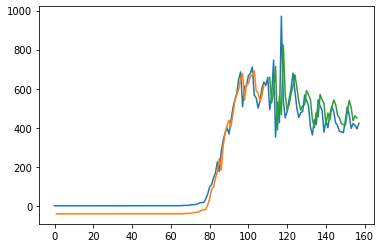

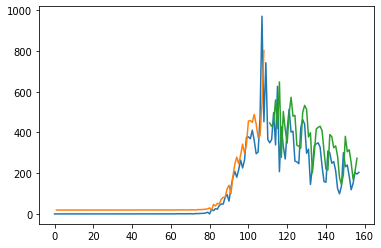

France


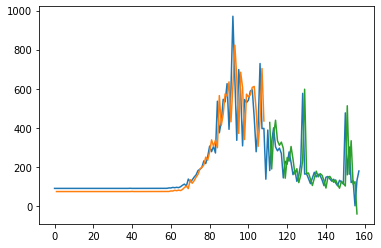

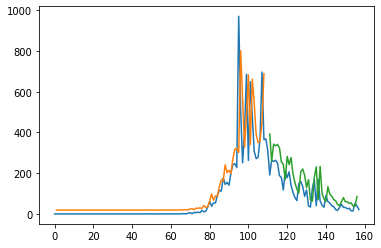

Italy


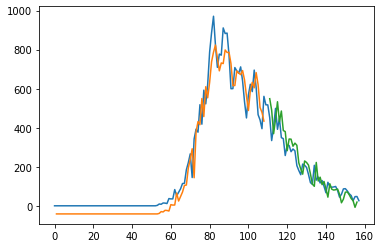

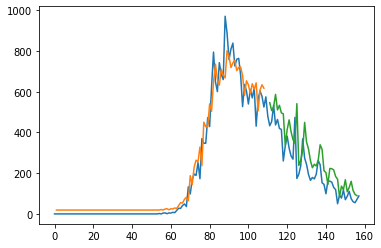

In [15]:
for ctc in ctclist:
  print(ctc)
  # shift train predictions for plotting
  trainPredictPlot_cases = np.empty_like(datasets_cases[ctc])
  trainPredictPlot_cases[:, :] = np.nan
  trainPredictPlot_cases[look_back:len(trainPredicts_cases[ctc])+look_back, :] = trainPredicts_cases[ctc]
  # shift test predictions for plotting
  testPredictPlot_cases = np.empty_like(datasets_cases[ctc])
  testPredictPlot_cases[:, :] = np.nan
  testPredictPlot_cases[len(trainPredicts_cases[ctc])+(look_back*2)+1:len(datasets_cases[ctc])-1, :] = testPredicts_cases[ctc]
  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(datasets_cases[ctc]))
  plt.plot(trainPredictPlot_cases)
  plt.plot(testPredictPlot_cases)
  plt.show()

  # shift train predictions for plotting
  trainPredictPlot_deaths = np.empty_like(datasets_deaths[ctc])
  trainPredictPlot_deaths[:, :] = np.nan
  trainPredictPlot_deaths[look_back:len(trainPredicts_deaths[ctc])+look_back, :] = trainPredicts_deaths[ctc]
  # shift test predictions for plotting
  testPredictPlot_deaths = np.empty_like(datasets_deaths[ctc])
  testPredictPlot_deaths[:, :] = np.nan
  testPredictPlot_deaths[len(trainPredicts_deaths[ctc])+(look_back*2)+1:len(datasets_deaths[ctc])-1, :] = testPredicts_deaths[ctc]
  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(datasets_deaths[ctc]))
  plt.plot(trainPredictPlot_deaths)
  plt.plot(testPredictPlot_deaths)
  plt.show()